RMSE: 0.7290992247795264
MAE: 0.12840284561001045
Precision@5: 0.020119284294234593
Recall@5: 0.08073724320742212
MAP@5: 0.03971835652750165
Precision@10: 0.01606361829025845
Recall@10: 0.1285967528164347
MAP@10: 0.031713646691280885


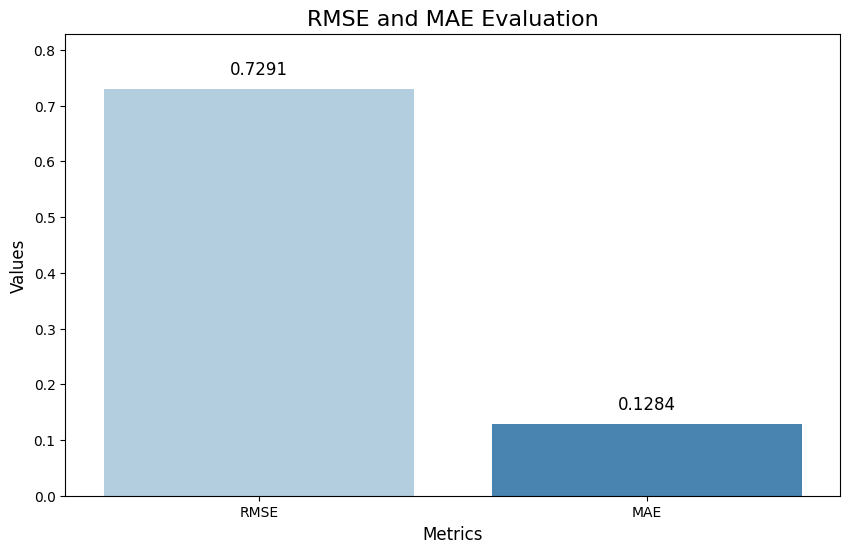

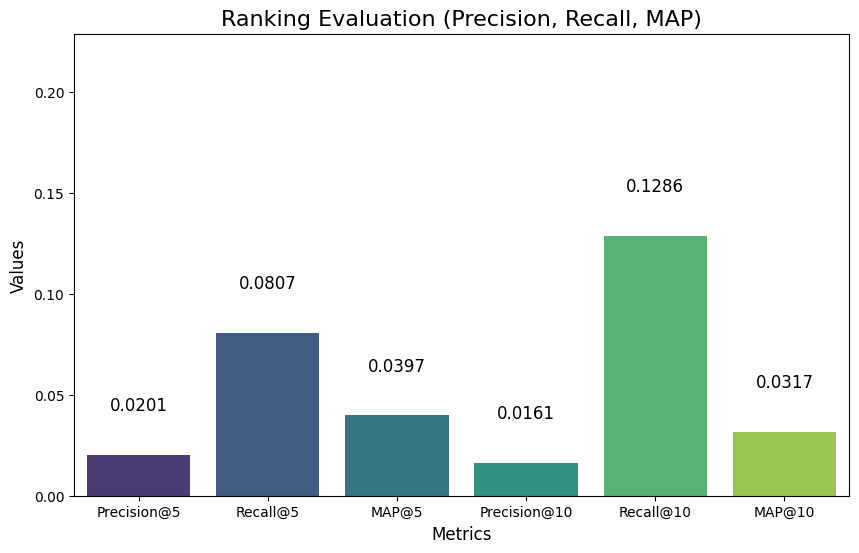

Top 5 recommendations for User 0: Index(['Pantai Lumban Bul-bul Balige', 'Wisata Rumah Pohon', 'Hatulian Beach',
       'Bukit Sibea-Bea', 'Bukit Sipolha'],
      dtype='object', name='item_id')
Top 10 recommendations for User 0: Index(['Pantai Lumban Bul-bul Balige', 'Wisata Rumah Pohon', 'Hatulian Beach',
       'Bukit Sibea-Bea', 'Bukit Sipolha',
       'Caldera toba nomadic escape (glamour camping)', 'Danau Toba Parapat',
       'Desa Meat', 'Desa Wisata Sigapiton', 'Dolok Pesona Panoguan Solu'],
      dtype='object', name='item_id')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Load the data (replace 'data.csv' with your actual file path)
df = pd.read_csv('Tempat-Wisata-Toba-Preprocessing.csv')

# Preprocessing the data
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'address', 'Reviews', 'Category', 'PlaceID'])
df = df.rename(columns={'ReviewerId': 'user_id', 'Nama_tempat_wisata': 'item_id', 'Rating': 'rating'})
df = df.groupby(['user_id', 'item_id'], as_index=False)['rating'].mean()

# Split data into training, validation, and testing sets (70%, 15%, 15%)
train, temp = train_test_split(df, test_size=0.3, random_state=42)
validation, test = train_test_split(temp, test_size=0.5, random_state=42)

# Pivot the dataframe into a user-item matrix
train_matrix = train.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
validation_matrix = validation.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
test_matrix = test.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Ensure that the columns in validation_matrix and test_matrix match those in train_matrix
validation_matrix = validation_matrix.reindex(columns=train_matrix.columns, fill_value=0)
test_matrix = test_matrix.reindex(columns=train_matrix.columns, fill_value=0)

# Standardize the data for KNN
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_matrix)
validation_scaled = scaler.transform(validation_matrix)
test_scaled = scaler.transform(test_matrix)

# Initialize KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# Fit the model using training data
knn.fit(train_scaled)

# Function to make predictions
def predict_ratings(knn, user_id, train_scaled, train_matrix, n_neighbors=5):
    distances, indices = knn.kneighbors(train_scaled[user_id].reshape(1, -1), n_neighbors=n_neighbors)

    predicted_ratings = np.zeros(train_matrix.shape[1])

    for i, index in enumerate(indices.flatten()):
        predicted_ratings += train_matrix.iloc[index] * (1 - distances[0][i])

    predicted_ratings /= len(indices.flatten())  # Averaging the predictions

    return predicted_ratings

# Evaluate the model using RMSE and MAE
def evaluate_model(knn, test_scaled, test_matrix):
    y_true = test_matrix.values
    y_pred = np.zeros_like(y_true)

    for user_id in range(test_matrix.shape[0]):
        y_pred[user_id] = predict_ratings(knn, user_id, train_scaled, train_matrix)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAE
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, mae, y_true, y_pred

# Function to calculate Precision@k, Recall@k, and MAP
def calculate_precision_recall_map(y_true, y_pred, k=5):
    precision_scores = []
    recall_scores = []
    average_precisions = []

    for i in range(y_true.shape[0]):
        # Get the top k recommendations
        top_k_indices = np.argsort(y_pred[i])[-k:]

        # True positive items (rated by user)
        relevant_items = set(np.where(y_true[i] > 0)[0])  # Items with non-zero ratings
        recommended_items = set(top_k_indices)

        # Precision@k
        precision = len(relevant_items.intersection(recommended_items)) / k
        precision_scores.append(precision)

        # Recall@k
        recall = len(relevant_items.intersection(recommended_items)) / len(relevant_items) if len(relevant_items) > 0 else 0
        recall_scores.append(recall)

        # Average Precision (AP)
        avg_precision = 0
        relevant_count = 0
        for j, item in enumerate(top_k_indices):
            if item in relevant_items:
                relevant_count += 1
                avg_precision += relevant_count / (j + 1)
        if relevant_count > 0:
            avg_precision /= relevant_count
        average_precisions.append(avg_precision)

    # MAP (Mean Average Precision)
    map_score = np.mean(average_precisions)

    # Average Precision and Recall across all users
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)

    return avg_precision, avg_recall, map_score

# Evaluate the model on the test set and calculate Precision, Recall, MAP
rmse, mae, y_true, y_pred = evaluate_model(knn, test_scaled, test_matrix)
precision_5, recall_5, map_5 = calculate_precision_recall_map(y_true, y_pred, k=5)
precision_10, recall_10, map_10 = calculate_precision_recall_map(y_true, y_pred, k=10)

# Output the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'Precision@5: {precision_5}')
print(f'Recall@5: {recall_5}')
print(f'MAP@5: {map_5}')
print(f'Precision@10: {precision_10}')
print(f'Recall@10: {recall_10}')
print(f'MAP@10: {map_10}')

# Plotting the evaluation metrics
metrics_1 = ['RMSE', 'MAE']
values_1 = [rmse, mae]

metrics_2 = ['Precision@5', 'Recall@5', 'MAP@5', 'Precision@10', 'Recall@10', 'MAP@10']
values_2 = [precision_5, recall_5, map_5, precision_10, recall_10, map_10]

# Plotting RMSE and MAE
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_1, y=values_1, hue=metrics_1, palette='Blues', legend=False)
for i, v in enumerate(values_1):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=12)
plt.title('RMSE and MAE Evaluation', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.ylim(0, max(values_1) + 0.1)
plt.show()

# Plotting Precision, Recall, MAP
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_2, y=values_2, hue=metrics_2, palette='viridis', legend=False)
for i, v in enumerate(values_2):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=12)
plt.title('Ranking Evaluation (Precision, Recall, MAP)', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.ylim(0, max(values_2) + 0.1)
plt.show()

# Recommending top 5 and top 10 places
def recommend_top_k(knn, user_id, train_scaled, train_matrix, k=5):
    predicted_ratings = predict_ratings(knn, user_id, train_scaled, train_matrix, n_neighbors=k)
    top_k_indices = np.argsort(predicted_ratings)[-k:][::-1]  # Sort by highest predicted rating
    recommended_places = train_matrix.columns[top_k_indices]
    return recommended_places

# Get top 5 and top 10 recommendations for a specific user (for example, user_id=0)
user_id = 0
top_5 = recommend_top_k(knn, user_id, train_scaled, train_matrix, k=5)
top_10 = recommend_top_k(knn, user_id, train_scaled, train_matrix, k=10)

print(f"Top 5 recommendations for User {user_id}: {top_5}")
print(f"Top 10 recommendations for User {user_id}: {top_10}")

In [ ]:
print(df.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'address', 'PlaceID',
       'Nama_tempat_wisata', 'Category', 'ReviewerId', 'Rating', 'Reviews'],
      dtype='object')


In [ ]:
# Pastikan kolom yang digunakan ada
print(df[['item_id', 'rating']].head())  # Lihat beberapa data pertama